In [1]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout,Layer

In [2]:
class MyModel(Model):
  def __init__(self, num_classes, **kwargs):
    super(MyModel,self).__init__(**kwargs)
    self.dense1 = Dense(16,activation=tf.nn.sigmoid)
    self.dropout = Dropout(0.5)
    self.dense2 = Dense(num_classes,activation=tf.nn.softmax)

  
  def call(self,inputs,training=False):
    h = self.dense1(inputs)
    y = self.dense1(inputs)
    h = self.dropout(h,training=training)
    fin = tf.concat([h,y],axis=0)
    return self.dense2(fin)


my_model = MyModel(12,name="Lol")
my_model(tf.random.uniform([1,10]))
my_model.summary()

Model: "Lol"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  176       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  204       
Total params: 380
Trainable params: 380
Non-trainable params: 0
_________________________________________________________________


In [20]:
class Sigmoid(Layer):
  """Bisa jadi Salah ,Masi Belajar aku """
  def __init__(self,input_dim,units):
    super().__init__()
    weight_init = tf.random_normal_initializer()
    bias_init = tf.zeros(shape=(units))
    self.w = tf.Variable(initial_value=weight_init(shape=(input_dim,units)))
    self.b = tf.Variable(initial_value=bias_init)
  def call(self, inputs):
    matmul = tf.add(tf.matmul(inputs, self.w) , self.b)
    return 1 / (1 + tf.exp(-matmul)) 

class DenseCustom(Layer):
  def __init__(self,units,**kwargs):
    super().__init__(**kwargs)
    self.units= units

  def build(self,input_shape):
    print(input_shape)
    self.weight = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer=tf.random.normal)
    self.bias = self.add_weight(shape=(self.units),
                                initializer=tf.zeros)
  def call(self,inputs): 
    return tf.matmul(inputs,self.weight) + self.bias


sig = Sigmoid(15,4)
inputs = tf.ones((3,15))
print(sig(inputs))

Dens = DenseCustom(5)
x = tf.ones(shape=(2,10))
print(Dens(x))

tf.Tensor(
[[0.5279577  0.582747   0.5096473  0.54328877]
 [0.5279577  0.582747   0.5096473  0.54328877]
 [0.5279577  0.582747   0.5096473  0.54328877]], shape=(3, 4), dtype=float32)
(2, 10)
tf.Tensor(
[[ 3.2745876  2.7722564 -1.992646   3.754048   3.169958 ]
 [ 3.2745876  2.7722564 -1.992646   3.754048   3.169958 ]], shape=(2, 5), dtype=float32)


In [4]:
def layerMean(Layer):
  def __init__(self,units,input_dim):
    super().__init__()
    self.weight = self.add_weight(shape=(input_dim,units),initializer=tf.random.normal)
    self.bias = self.add_weight(shape=(units),initializer=tf.ones)
    self.sum_Activation = tf.Variable(initial_value=tf.zeros(shape=(units)),trainable=False)
    self.num_Calls = tf.Variable(initial_value=0,trainable=False)

  def call(self,inputs):
    activations = tf.matmul(inputs,self.weight) + self.bias
    self.sum_Activation.assign_add(tf.reduce_mean(activations,axis=0))
  

In [22]:
 x = tf.constant(2.0)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = x**2
  grad = tape.gradient(target=y,sources=x) 

print(grad) 

tf.Tensor(4.0, shape=(), dtype=float32)


In [23]:
x = tf.constant([0,1,2,3],dtype=tf.float32)

with tf.GradientTape() as tape:
  tape.watch(x)
  print(tf.reduce_sum(x**2,axis=None))
  y = tf.reduce_sum(x**2)
  z = tf.math.sin(y)
  dz_dy = tape.gradient(target=z,sources=y)

print(dz_dy)

tf.Tensor(14.0, shape=(), dtype=float32)
tf.Tensor(0.13673721, shape=(), dtype=float32)


In [24]:
x = tf.constant([0,1,2,3],dtype=tf.float32)

with tf.GradientTape() as tape:
  tape.watch(x)
  print(tf.reduce_sum(x**2,axis=None))
  y = tf.reduce_sum(x**2)
  z = tf.math.sin(y)
  dz_dy,dz_dx = tape.gradient(target=z,sources=[y,x])

print(dz_dy)
print(dz_dx)

tf.Tensor(14.0, shape=(), dtype=float32)
tf.Tensor(0.13673721, shape=(), dtype=float32)
tf.Tensor([0.         0.27347443 0.54694885 0.82042325], shape=(4,), dtype=float32)


In [51]:
import matplotlib.pyplot as plt
import numpy as np

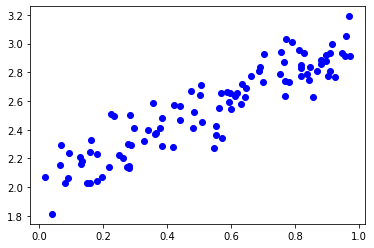

In [66]:
def atLeastNoisy(m,b,n = 100):
  x =tf.random.uniform(shape=(n,))
  noise = tf.random.normal(shape=(len(x),),stddev=0.12)
  y = m * x +b + noise
  return x,y

m= 1
b = 2
x_train,y_train = atLeastNoisy(m,b)
plt.plot(x_train,y_train,"bo")

starting loss 1.2110544
m:1, Trained m :[-1534.2894]
b:1, Trained b :[-2714.4436]


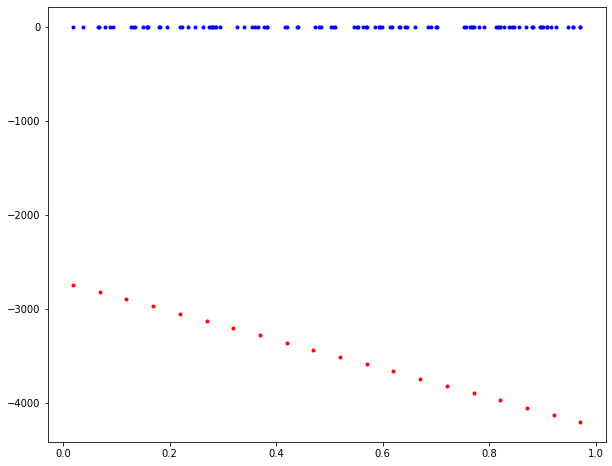

In [68]:
class LinLayer(Layer):
  def __init__(self,**kwargs):
    super().__init__(**kwargs)

  def build(self,input_shape):
    self.weight = self.add_weight(shape=(1,),
                                  initializer=tf.random.uniform)
    self.bias = self.add_weight(shape=(1,),
                                initializer=tf.ones)

  def call(self,inputs):
    return inputs * self.weight + self.bias

linReg = LinLayer()
linReg(x_train)

def squaredError(y_pred,y_true):
  return tf.reduce_mean(tf.square(y_pred - y_true))

loss = squaredError(linReg(x_train),y_train)
print("starting loss", loss.numpy())

learning_rate =0.1
steps=35

for step in range(steps):
  with tf.GradientTape() as tape:
    predictions = linReg(x_train)
    loss = squaredError(predictions,y_train)
  
  gradients = tape.gradient(loss,linReg.trainable_variables)
  linReg.weight.assign_add(learning_rate*gradients[0])
  linReg.bias.assign_add(learning_rate*gradients[1])

plt.figure(figsize=(10,8))
print("m:{}, Trained m :{}".format(m,linReg.weight.numpy()))
print("b:{}, Trained b :{}".format(m,linReg.bias.numpy()))

plt.plot(x_train,y_train,"b.")

x_linear_reg =np.linspace(min(x_train),max(x_train),20)
plt.plot(x_linear_reg,linReg.weight * x_linear_reg + linReg.bias,'r.')


m:1, Trained m :[-1420.121]
b:1, Trained b :[-2500.9324]


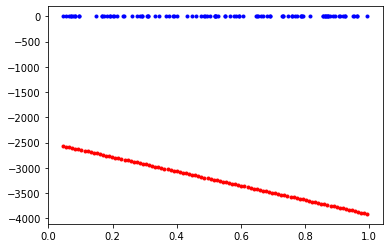

In [57]:
print("m:{}, Trained m :{}".format(m,linReg.weight.numpy()))
print("b:{}, Trained b :{}".format(m,linReg.bias.numpy()))

plt.plot(x_train,y_train,"b.")

x_linear_reg =np.linspace(min(x_train),max(x_train),100)
plt.plot(x_linear_reg,linReg.weight * x_linear_reg + linReg.bias,'r.')

In [ ]:
#Lets Try IT